<a href="https://colab.research.google.com/github/Rhabibi1609/Fairness-Aware-Logistic-Regression-Using-Demographic-Parity-and-Balance-Metrics/blob/main/logReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sklearn
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import defaultdict
import copy

np.random.seed(46249424) #Cause it was giving me random new selection values at every execution...

In [ ]:
STUDENT_ID = 46249424

In [ ]:
def make_dataset(student_id = STUDENT_ID):
    """used make classificaiton from scikitlearn to generate a dataser with sample size 700, 2 features, no repeated features with my id as seed for random generation  """
    X, y = make_classification(n_samples=700, n_features=2, n_redundant=0, n_repeated=0, flip_y=0, class_sep=2.5, random_state=STUDENT_ID,n_clusters_per_class=1)

    G = np.empty(len(y), dtype=str)  # Initialize group array

    for i in range(len(y)):
        if y[i] == 1:  # Selection class
            G[i] = 'A' if np.random.rand() < 0.6 else 'B'  #For A to have selection majority
        else:  # Rejection class
            G[i] = 'B' if np.random.rand() < 0.6 else 'A'  #Increased rejection majority for B
    return X, y, G



X, y, G = make_dataset() #X is the dataset, y are the ground truth labels, and G are the protected group labels

In [ ]:
#Displaying datase
groupCounts = defaultdict(int)

#Moving through indices
for i in range(len(y)):
    label = y[i]
    group = G[i]
    groupCounts[(label, group)] += 1

# Extracting unique labels and groups
uniquelabels = sorted(set(y))
uniquegroups = sorted(set(G))


print(f"Group     {uniquegroups} \nLabel")
for label in uniquelabels:
    row = [groupCounts.get((label, group), 0) for group in uniquegroups]
    print(f"{label}        ", row)

Group     ['A', 'B'] 
Label
0         [107, 243]
1         [200, 150]


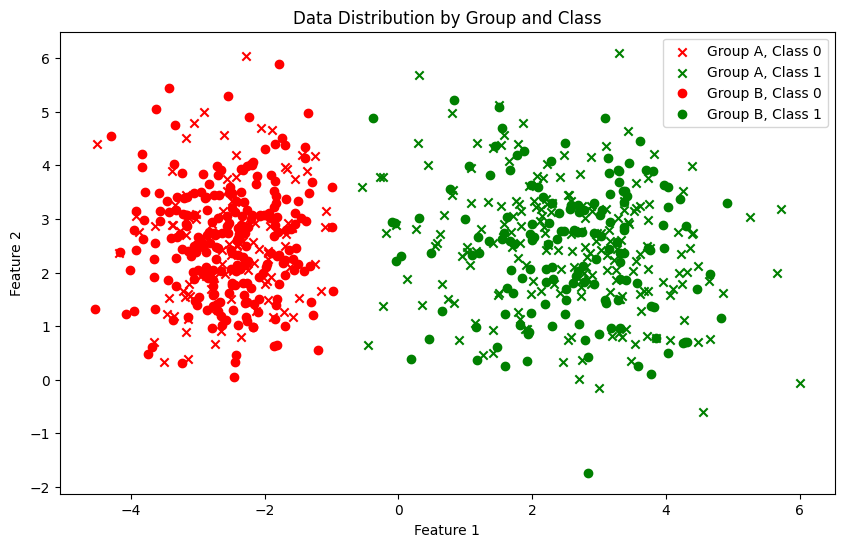

In [ ]:

def make_plot(X, y, G):
    plt.figure(figsize=(10, 6))
    groups = ['A','B']
    markers = ['x','o']
    labels = [0,1]
    colors = ['red','green']
    for i in range(len(groups)):
        group = groups[i]
        marker = markers[i]
        for j in range(len(labels)):
            label = labels[j]
            color = colors[j]
            idx = np.where((np.array(G) == group) & (y == label))
            plt.scatter(X[idx, 0], X[idx, 1], c=color, marker=marker, label=f'Group {group}, Class {label}')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.title('Data Distribution by Group and Class')
    plt.show()


make_plot(X, y, G) #Obtain the data distribution plot

In [ ]:
def train_logistic_regression(X,y):
    """Training data on model"""
    model = LogisticRegression()
    model.fit(X, y)
    return model



model = train_logistic_regression(X,y) #Obtain trained LR model
print(f"Training Accuracy: {accuracy_score(y, model.predict(X))}")

Training Accuracy: 1.0


In [ ]:
def demographic_parity(y_pred, group_labels):
    """calculating the dp"""
    #Getting unique groups
    groups = list(set(group_labels))  # Extracting unique group labels (i.e A n B)

    #Computing the selection rate for each group
    rates = {}
    for group in groups:#Like A in A,B
        group_indices = [i for i in range(len(group_labels)) if group_labels[i] == group]#For A in A,B if A == A
        group_predictions = [y_pred[i] for i in group_indices]  # Extract predictions for this group
        rates[group] = sum(group_predictions) / len(group_predictions)  # Avoid division by zero
        print(sum(group_predictions))
        print(len(group_predictions))
        print(rates)

   #Computing demographic parity difference
    dp = abs(rates[groups[0]] - rates[groups[1]])

    return dp



dp = demographic_parity(model.predict(X), G)
print(f"Demographic Parity Difference: {dp}")

150
393
{'B': 0.3816793893129771}
200
307
{'B': 0.3816793893129771, 'A': 0.6514657980456026}
Demographic Parity Difference: 0.26978640873262544


In [ ]:
def balance(y_pred, X, G):
    """calculating balance"""
   # Step 1: Get unique clusters and groups (without np.unique)
    uniqueClusters = np.unique(y_pred)
    uniqueGroups = np.unique(G)

    balanceValues = []

    totalCounts = len(G)
    rgX={g:np.sum(G == g)/totalCounts for g in uniqueGroups}  #Storing overall proportions i.e for A and B

    for k in uniqueClusters:
        clusterindices = np.where(y_pred == k)[0]  # Get indices for cluster k
        clustersize = len(clusterindices)

        if clustersize == 0:
            continue

        rgk = {g: np.sum(G[clusterindices] == g) / clustersize for g in uniquegroups} #Computing proportions for group g in cluster k

        min_ratios = [min(rgk[g] / rgX[g], rgX[g] / rgk[g]) for g in uniqueGroups if rgk[g] > 0] #Compares proportion of each grp in cluster to overall population

        if min_ratios:
            balanceValues.append(min(min_ratios))
        bal = min(balanceValues) #the minimum value out of all the ratios

    return bal



print(f"Balance: {balance(model.predict(X), X, G)}")

Balance: 0.6970684039087948


New Training Accuracy: 1.0
220
463
{'B': 0.47516198704103674}
200
307
{'B': 0.47516198704103674, 'A': 0.6514657980456026}
New Demographic Parity Difference: 0.17630381100456582
New Balance: 0.7667752442996743
Group     ['A', 'B'] 
Label
0         [107, 243]
1         [200, 220]


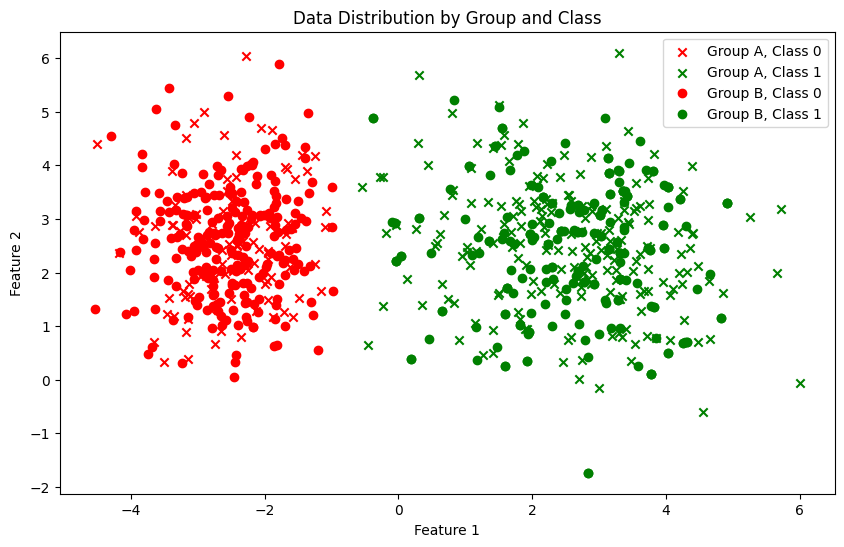

In [ ]:

def update_data(X, y, G, budget=0.1*len(X)):
    """trying to improve fairness by adding samples."""

    X_updated, y_updated, G_updated = list(X), list(y), list(G)

    # Computing the starting selection rates
    y_pred = model.predict(X)
    SelectionA = sum((y_pred == 1) & (np.array(G) == 'A')) / sum(np.array(G) == 'A')
    SelectionB = sum((y_pred == 1) & (np.array(G) == 'B')) / sum(np.array(G) == 'B')

    changes = 0  # Tracking the number of modifications



    np.random.seed(46249424)  #for reproducibility
    while changes < budget:
        # Generating new samples similar to existing ones
        if SelectionA > SelectionB:
            new_X = X[np.random.choice(np.where((np.array(G) == 'B') & (y == 1))[0])]
            X_updated.append(new_X)
            y_updated.append(1)
            G_updated.append('B')
        else:
            new_X = X[np.random.choice(np.where((np.array(G) == 'A') & (y == 0))[0])]
            X_updated.append(new_X)
            y_updated.append(0)
            G_updated.append('A')

        changes += 1

    return np.array(X_updated), np.array(y_updated), np.array(G_updated)


# Applying the update function
X_prime, y_prime, G_prime = update_data(X, y, G)

# Training new model
model_prime = train_logistic_regression(X_prime, y_prime)
print(f"New Training Accuracy: {accuracy_score(y, model_prime.predict(X))}")

#new dp and balance
new_dp = demographic_parity(model_prime.predict(X_prime), G_prime)
new_balance = balance(model_prime.predict(X_prime), X_prime, G_prime)

print(f"New Demographic Parity Difference: {new_dp}")
print(f"New Balance: {new_balance}")

groupCounts = defaultdict(int)

#to present data
for i in range(len(y_prime)):
    label = y_prime[i]
    group = G_prime[i]
    groupCounts[(label, group)] += 1


uniquelabels = sorted(set(y_prime))
uniquegroups = sorted(set(G_prime))


print(f"Group     {uniquegroups} \nLabel")
for label in uniquelabels:
    row = [groupCounts.get((label, group), 0) for group in uniquegroups]
    print(f"{label}        ", row)


make_plot(X_prime, y_prime, G_prime)

In [ ]:
print(new_dp - dp)

-0.09348259772805961


In [ ]:
print(new_balance - balance(model.predict(X), X, G))

0.06970684039087949
